#### Libraries

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import numpy as np
from numpy import expand_dims
import argparse
import os
import glob
import xmltodict
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET # copy of xml
from xml.etree.ElementTree import parse
import cv2
from skimage import io
from scipy.signal import convolve2d
from PIL import Image  
import PIL 
import urllib
from urllib.request import urlopen
from typing import Tuple, List, Dict
from bs4 import BeautifulSoup
import requests
from io import BytesIO
from keras.applications import MobileNetV2
from keras import layers
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator # load the image
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from keras.utils import to_categorical
from keras import backend as K


## Load and transform images

#### Creation of URLs for images and annotations

In [4]:
prefix_url_imgs = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/"
number_of_imgs = 766 # +1 to include last one (765)

list_imgs = []

for i in range(0, number_of_imgs):
    i = str(i)
    var_imgs = "BikesHelmets" + i + ".png"
    var_imgs_url = prefix_url_imgs + var_imgs
    list_imgs.append(var_imgs_url)

#for i in range(0, len(list_imgs)):
#    response = requests.get(list_imgs[i])
#    img = Image.open(BytesIO(response.content))
#    plt.imshow(img)

In [5]:
prefix_url_xml = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/annotations/"
number_of_annt = 766 # +1 to include last one (765)

list_annotations= []

for i in range(0, number_of_annt):
    i = str(i)
    var_annt = "BikesHelmets" + i + ".xml"
    var_annt_url = prefix_url_xml + var_annt
    list_annotations.append(var_annt_url)

### Augmentantion functions

In [26]:
def picture_zoom(image):
   # to array
   array = expand_dims(image[1], 0)
   # create image data augmentation generator
   datagen_zoom= ImageDataGenerator(zoom_range=[0.8,1.5])
   # prepare iterator
   it_zoom = datagen_zoom.flow(array, batch_size=1)
   # generate batch of images
   batch_zoom = it_zoom.next()
   # convert to unsigned integers for viewing
   image_zoom = batch_zoom[0].astype('uint64')
   # returning list
   list = [image[0], image_zoom, image[2], image[3]]
   return list

In [27]:
def picture_rotation(image):
    # to array
    array = expand_dims(image[1], 0)
    # ImageDataGenerator rotation
    datagen_rotation=ImageDataGenerator(rotation_range=45, fill_mode='nearest')
    # prepare iterator
    it_rotation = datagen_rotation.flow(array, batch_size=1)
    # generate batch of images
    batch_rotation = it_rotation.next()
    # convert to unsigned integers for viewing
    image_rotation = batch_rotation[0].astype('uint64')
    # plot raw pixel 
    img_rotation=plt.imshow(image_rotation, interpolation ='None', filternorm=True) #spline36, antialiased
    # returning list
    list = [image[0], image_rotation, image[2], image[3]]
    return list

In [28]:
def picture_brightness(image):
    # to array
    array = expand_dims(image[1], 0)
    # create image data augmentation generator
    datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])
    # prepare iterator
    it_brightness = datagen_brightness.flow(array, batch_size=1)
    # generate batch of images
    batch_zoom = it_brightness.next()
    # convert to unsigned integers for viewing
    image_brightness = batch_zoom[0].astype('uint64')
    # plot raw pixel 
    img_brightness=plt.imshow(image_brightness, interpolation ='None')
    # returning list
    list = [image[0], image_brightness, image[2], image[3]]
    return list

### Retrieving and labelling images from XML annotations

#### Full images
* no bounding box, multiple faces per image
* for images with multiple people, if and only if all people wear helmet the label would be 1, otherwise label would be 0.

In [6]:
full_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            a = 0
            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            resized = img_temp.resize((224,224)) # resize all images to 224x224
            image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
            
            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        if i['name'] == 'With Helmet':
                            a =+1
                        else:
                            a =+0
                    if a > 0 :
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else :
                        full_imgs.append([tags['filename'], image, 0, img_path])
                
                if isinstance(tags['object'], dict):
                    if tags['object']['name'] == 'With Helmet':
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else:
                        full_imgs.append([tags['filename'], image, 0, img_path])
            else:
                pass
    except:
        pass

* Augment full images

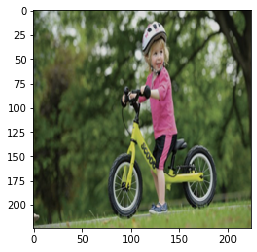

In [30]:
# Augmentantion of full images
augm_full_imgs = []
for i in range(0, len(full_imgs)+1):
    try:
        augm_full_imgs.append(picture_zoom(full_imgs[i]))
        augm_full_imgs.append(picture_rotation(full_imgs[i]))
        augm_full_imgs.append(picture_brightness(full_imgs[i]))
    except:
        pass

In [42]:
# consolidate initial with augmented images in one list
final_full_imgs = full_imgs + augm_full_imgs

print("Total full images:", len(final_full_imgs))
print("of which initial images:", len(full_imgs))
print("of which augmented images:", len(augm_full_imgs))

Total full images: 3044
of which initial images: 761
of which augmented images: 2283


* Transform full images to model inputs

In [75]:
# Transforming images in a proper array for model input
full_imgs_array = []
for i in range(0, len(final_full_imgs)+1):
    try:
        full_imgs_array.append(np.array(final_full_imgs[i][1]))
    except:
        pass
full_imgs_array = np.array(full_imgs_array, dtype='int')

In [51]:
# shape of new array
full_imgs_array.shape

(3044, 224, 224, 3)

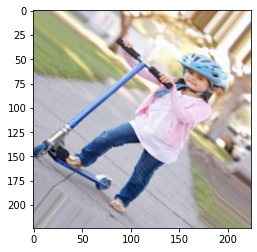

In [58]:
# testing that images appear correctly
plt.imshow(full_imgs_array[1500])

In [59]:
# reshape of array
full_imgs_array_rshp = full_imgs_array.reshape(len(final_full_imgs), 224*224*3)

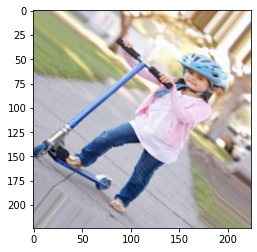

In [61]:
# testing that images appear correctly
plt.imshow(full_imgs_array_rshp[1500].reshape(224, 224, 3))

In [62]:
# normalize colors
full_imgs_array_final = full_imgs_array_rshp.astype('float32') / 255

In [64]:
# final shape of input array
full_imgs_array_final.shape

(3044, 150528)

In [70]:
# Creating an array with labels
labels_array = []
for i in range(0, len(final_full_imgs)+1):
    try:
        labels_array.append(np.array(final_full_imgs[i][2]))
    except:
        pass
labels_array = np.array(labels_array, dtype='int')

In [71]:
# Categorically encode the labels
full_imgs_labels = to_categorical(labels_array)

#### Cropped images
* bounding box on heads, creation of multiple images per image

In [91]:
cropped_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            image = cv2.cvtColor(np.array(img_temp), cv2.INPAINT_TELEA)
            mask = np.zeros(image.shape, dtype = 'int32')

            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        xmin = int(i['bndbox']['xmin'])
                        ymin = int(i['bndbox']['ymin'])
                        xmax = int(i['bndbox']['xmax'])
                        ymax = int(i['bndbox']['ymax'])
                        if i['name'] == 'With Helmet':
                            mask = cv2.rectangle(mask, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                            result = cv2.addWeighted(image, 1, mask, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path])
                            #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                            
                        else:
                            cv2.rectangle(mask, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                            result = cv2.addWeighted(image, 1, mask, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                            
                            #plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                if isinstance(tags['object'], dict):
                    xmin = int(tags['object']['bndbox']['xmin'])
                    ymin = int(tags['object']['bndbox']['ymin'])
                    xmax = int(tags['object']['bndbox']['xmax'])
                    ymax = int(tags['object']['bndbox']['ymax'])
                    if tags['object']['name'] == 'With Helmet':
                        cv2.rectangle(mask, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                        result = cv2.addWeighted(image, 1, mask, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path])
                        #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                    else:
                        cv2.rectangle(mask, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                        result = cv2.addWeighted(image, 1, mask, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                    # plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
            else:
                pass
    except:
        pass

* Augment cropped images

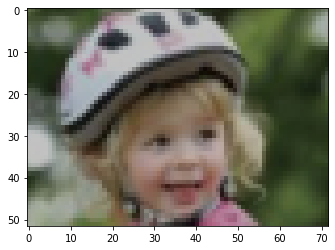

In [100]:
# Augmentantion of cropped images
augm_cropped_imgs = []
for i in range(0, len(cropped_imgs)+1):
    try:
        #augm_cropped_imgs.append(picture_zoom(cropped_imgs[i]))
        augm_cropped_imgs.append(picture_rotation(cropped_imgs[i]))
        augm_cropped_imgs.append(picture_brightness(cropped_imgs[i]))
    except:
        pass

In [142]:
# consolidate initial cropped images with augmented in one list
all_cropped_imgs = cropped_imgs + augm_cropped_imgs

In [143]:
# checking average height and width of images
x = 0
y = 0
itt = len(all_cropped_imgs)
for i in range(0, len(all_cropped_imgs)+1):
    try:
        tmp_shape = all_cropped_imgs[i][1].shape
        x += tmp_shape[0]
        y += tmp_shape[1]
    except:
        itt -=1
        pass

print(round(x/itt,0))
print(round(y/itt,0))

46.0
42.0


In [185]:
# all images must have the same size
# as we cannot resize the images during the load of them because this maybe 
# would have a negative effect on bounding box coordinates, the resize is happening hear
all_cropped_imgs_v2 = []
for i in range(1, len(all_cropped_imgs)):
    try:
        img_temp =array_to_img(all_cropped_imgs[i][1])
        resized = img_temp.resize((40,40)) # resize all images to 40x40
        image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
        all_cropped_imgs_v2.append([all_cropped_imgs[i][0], image, all_cropped_imgs[i][2], all_cropped_imgs[i][3]])
    except:
        pass

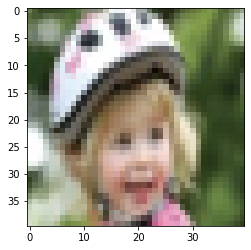

In [189]:
plt.imshow(all_cropped_imgs_v2[4300][1], interpolation='nearest')

In [190]:
print("Total cropped images:", len(all_cropped_imgs_v2))
print("of which initial cropped images:", len(cropped_imgs))
print("of which augmented cropped images:", (len(all_cropped_imgs_v2)-len(cropped_imgs)))

Total cropped images: 4301
of which initial cropped images: 1451
of which augmented cropped images: 2850


* Transform cropped images to model inputs

In [193]:
# Transforming images in a proper array for model input
cropped_imgs_array = []
for i in range(0, len(all_cropped_imgs_v2)):
    try:
        cropped_imgs_array.append(np.array(all_cropped_imgs_v2[i][1]))
    except:
        pass
cropped_imgs_array = np.array(cropped_imgs_array, dtype='int')

In [194]:
# shape of new array
cropped_imgs_array.shape

(4301, 40, 40, 3)

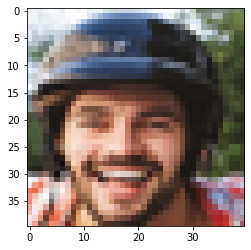

In [195]:
# testing that images appear correctly
plt.imshow(cropped_imgs_array[1500])

In [196]:
# reshape of array
cropped_imgs_array_rshp = cropped_imgs_array.reshape(len(all_cropped_imgs_v2), 40*40*3)

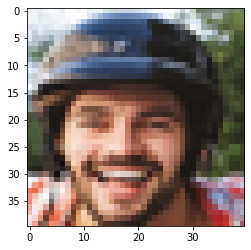

In [198]:
# testing that images appear correctly
plt.imshow(cropped_imgs_array_rshp[1500].reshape(40, 40, 3))

In [199]:
# normalize colors
cropped_imgs_array_final = cropped_imgs_array_rshp.astype('float32') / 255

In [203]:
# final shape of input array
cropped_imgs_array_final.shape

(4301, 4800)

In [202]:
# Creating an array with labels
labels_array_cropped = []
for i in range(0, len(cropped_imgs_array_final)+1):
    try:
        labels_array_cropped.append(np.array(cropped_imgs_array_final[i][2]))
    except:
        pass
labels_array_cropped = np.array(labels_array_cropped, dtype='int')

In [204]:
# Categorically encode the labels
cropped_imgs_labels = to_categorical(labels_array_cropped)

## Models

#### Simple model - full images

In [210]:
network = models.Sequential()

network.add(layers.Dense(512,
                         activation='relu',
                         input_shape=(224 * 224 * 3,)))

network.add(layers.Dense(2,
                         activation='softmax'))

In [73]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [74]:
# We’re now ready to train the network
network.fit(full_imgs_array_final, 
            full_imgs_labels,
            epochs=10,
            batch_size=128,
            validation_split=0.1)

Epoch 1/10
22/22 [==============================] - 24s 1s/step - loss: 88.3605 - accuracy: 0.5352 - val_loss: 4.7022 - val_accuracy: 0.6656
Epoch 2/10
22/22 [==============================] - 22s 982ms/step - loss: 12.7511 - accuracy: 0.5582 - val_loss: 1.8762 - val_accuracy: 0.5082
Epoch 3/10
22/22 [==============================] - 21s 946ms/step - loss: 10.7386 - accuracy: 0.5615 - val_loss: 4.9283 - val_accuracy: 0.6656
Epoch 4/10
22/22 [==============================] - 21s 939ms/step - loss: 10.1455 - accuracy: 0.5655 - val_loss: 1.2552 - val_accuracy: 0.6590
Epoch 5/10
22/22 [==============================] - 21s 938ms/step - loss: 8.0715 - accuracy: 0.5622 - val_loss: 11.3130 - val_accuracy: 0.6656
Epoch 6/10
22/22 [==============================] - 21s 937ms/step - loss: 6.6063 - accuracy: 0.5776 - val_loss: 13.6942 - val_accuracy: 0.6656
Epoch 7/10
22/22 [==============================] - 21s 971ms/step - loss: 6.5111 - accuracy: 0.5674 - val_loss: 4.0310 - val_accuracy: 0.6

#### Simple model - cropped images

In [206]:
network = models.Sequential()

network.add(layers.Dense(512,
                         activation='relu',
                         input_shape=(40 * 40 * 3,)))

network.add(layers.Dense(2,
                         activation='softmax'))

In [207]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [208]:
# We’re now ready to train the network
network.fit(cropped_imgs_array_final, 
            cropped_imgs_labels,
            epochs=10,
            batch_size=128,
            validation_split=0.1)

Epoch 1/10
31/31 [==============================] - 2s 43ms/step - loss: 0.7651 - accuracy: 0.9295 - val_loss: 0.1372 - val_accuracy: 0.9907
Epoch 2/10
31/31 [==============================] - 1s 40ms/step - loss: 0.2621 - accuracy: 0.9553 - val_loss: 0.0386 - val_accuracy: 0.9907
Epoch 3/10
31/31 [==============================] - 1s 41ms/step - loss: 0.1679 - accuracy: 0.9700 - val_loss: 0.0369 - val_accuracy: 0.9907
Epoch 4/10
31/31 [==============================] - 1s 39ms/step - loss: 0.1741 - accuracy: 0.9682 - val_loss: 0.0411 - val_accuracy: 0.9907
Epoch 5/10
31/31 [==============================] - 1s 40ms/step - loss: 0.1678 - accuracy: 0.9698 - val_loss: 0.0327 - val_accuracy: 0.9907
Epoch 6/10
31/31 [==============================] - 1s 41ms/step - loss: 0.1408 - accuracy: 0.9698 - val_loss: 0.2049 - val_accuracy: 0.9907
Epoch 7/10
31/31 [==============================] - 1s 39ms/step - loss: 0.1428 - accuracy: 0.9711 - val_loss: 0.0666 - val_accuracy: 0.9907
Epoch 8/10
31